## Métricas de Coerência de tópicos

## Introdução

A modelagem de tópicos é o campo da IA que visa descrever o comportamento de um conjunto de textos a partir de outros dois conjuntos: Os tópicos e as palavras.

De forma simples, um **tópico** pode ser entendido como um 'subconjunto' de todas as palavras do vocabulário.
O exemplo de um possível tópico seria: 'circle, square, triangle, sphere, ...'

Na prática, os algoritmos criam tópicos pela atribuição de um grau de importância a cada palavra do vocabulário.
Por exemplo, '0.99 circle, 0.90 square, 0.89 triangle, 0.87 sphere, ... 0.01 gato, 0.001 cachorro'

Nós usualmente só estamos interessados nas palavras mais importantes de cada tópico, pois são elas que podem nos dar uma ideia do assunto que ele representa. 

Entretanto, como esses algoritmos se baseam puramente em análises matemáticas, a criação desses tópicos não necessáriamente segue algum sentido 'humano', e tópicos estatisticamente bem embasados podem não ter nenhum significado de um ponto de vista lógico. 

As métricas de coerência de tópicos foram criadas com o intuito de avaliar a **interpretabilidade** dos tópicos criados de um ponto de vista 'humano'.

Usualmente, quando nos referimos a 'coerência' estamos descrevendo uma característia cooperativa. Um conjunto de argumentos são 'coerentes' caso todos se confirmem entre si.

Portanto, uma métrica de coerência visa averiguar **o quão bem um conjunto de tópicos é suportado por um conjunto de textos**.

Muitas métricas de coerência de tópicos foram desenvolvidas tentando resolver este problema. Entretanto, diferentemente de métricas supervisionadas (e.g acurácia, MSE), não podemos nos basear em uma *ground truth* previamente calculada.

Röder, M. et al comenta em **Exploring the Space of Topic Coherence Measures** as principais características que uma métrica deve atender, e descreve a forma geral que uma métrica deve ter.

<a><img src="https://i.ibb.co/NxssM10/coherence-modules.png" alt="coherence-modules" border="0"></a>

Uma métrica é composta pelos seguintes módulos:

- Uma forma de segmentação ($S$) dos termos do vocabulário (tópicos e corpus)
- Uma forma de calcular probabilidades ($P$) associadas às palavras
- Uma medida de confirmação ($m$) que quantifica o quanto um tópico é suportado por um corpus textual
- Uma função agregadora ($\sigma$), que une todas as medidas de confirmação de cada tópico em um valor final.

$C = (S, P, m, \sigma)$

No artigo, foram testadas várias métricas, criadas pela variação de cada um dos módulos. Uma métrica é considerada boa se ela for capaz de mimicar bem as avaliações humanas sobre um conjunto de tópicos.

Uma lista dessas métricas pode ser encontradas em https://palmetto.demos.dice-research.org/

Neste material, vamos aplicar algumas das principais:

- $C_v$
- $C_{UMASS}$
- $C_{UCI}$
- $C_{NPMI}$




## As métricas

Para testar as métricas, usaremos a biblioteca **Gensim**.
Além disso, também é necessário um conjunto de textos de referência.

In [ ]:
!unzip wikipedia_br_scrapper_10k.zip

Archive:  wikipedia_br_scrapper_10k.zip
  inflating: wikipedia_br_scrapper_10k.csv  


In [ ]:
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

Os dados utilizados são um conjunto de 10K artigos da wikipedia em PT-BR.

In [ ]:
data = pd.read_csv('wikipedia_br_scrapper_10k.csv')
textos = data['text'].astype(str)

# Tokenizando e normalizando os textos
textos = textos.apply( lambda s: re.findall( '\w+', s.lower() ) ).tolist()

A título de exemplo, vamos utilizar os tópicos abaixo:

In [ ]:
topics = [ ['amor', 'ódio', 'paixão', 'emoção'], 
           ['elétron', 'eletromagnetismo', 'radioatividade'],
           ['gato', 'porta', 'estômago'],
           ['avião', 'aerodinâmica', 'ar'],
           ['danos', 'morais', 'justiça'] ]

### $C_v$ 

No site Palmetto, nós encontramos a seguinte descrição do $C_v$

> CV is based on a sliding window, a one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosinus similarity.
*Palmetto* 




Esta breve descrição detalha os módulos que compõem a métrica:

'*CV is based on a sliding window*' Diz que o método utilizado para cálculo das probabilidades se baseia em uma janela deslizante

'*a one-set segmentation of the top words*' Refere-se ao método aplicado para a segmentação (ou agrupamento) das palavras de cada tópico com o restante do vocabulário. 
'one-set' significa que cada palavra $w$ pertencente ao vocabulário $W'$ (top-n palavras mais inportantes em um tópico) será comparada com todo o vocabulário $W$ do corpus quando a medida de confirmação for aplicada.

No caso do $C_v$, os conjuntos são criados da seguinte forma:
<center>
$ S^{one}_{set} = \{ (W', W^*)| W' = {w_i}; w_i\in W; W^* = W \} $
</center>

'*an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosinus similarity*'. Esta sentença refere-se ao fato que a medida de confirmação entre duas palavras não é calculada diretamente. Ao invés disso, para $W'$ e $W^*$, são calculadas as confirmações de $W'$ e $W^*$ com todas as outras palavras de $W$ (com o NPMI) e o resultado final da confirmação entre elas é a a similaridade entre os vetores resultantes (com as similaridade cosseno).

<big>
<center>
$ \text{NPMI}(w_i, w_j) = \frac{\log \frac{P(w_i, w_j) + \epsilon}{P(w_i)P(w_j)} }{ -\log( P(w_i, w_j) + \epsilon ) } $
</center>
</big>
<center>
$\epsilon \approx 10^{-5}$ para prevenir zero no log
</center>


---

Vamos aplicar o $C_v$ utilizando o Gensim.

In [ ]:
# Criando dicionário com todos os termos do vocabulário
word2id = Dictionary( textos )

# Modelo de coerência
cm = CoherenceModel(topics=topics, 
                    coherence='c_v', texts=textos, 
                    dictionary=word2id, topn=10 )

Podemos obter o valor geral de coerência

In [ ]:
cm.get_coherence()

0.5982704707630526

Ou optar por calcular a coerência por tópico

In [ ]:
coherence_per_topic = cm.get_coherence_per_topic()
coherence_per_topic

[0.6350892764499032,
 0.7067607645354403,
 0.25820181365744516,
 0.8431652340245271,
 0.5481352651479472]

Visualizando melhor...

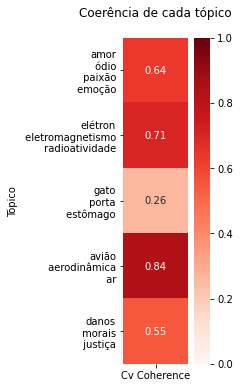

In [ ]:
topics_str = [ '\n '.join(t) for t in topics ]
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Tópico', 'Cv Coherence'] )
data_topic_score = data_topic_score.set_index('Tópico')

fig, ax = plt.subplots( figsize=(2,6) )
ax.set_title("Coerência de cada tópico\n")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f', vmax=1, vmin=0, 
            linecolor='black', ax=ax )

fig.show()

### $C_{UMASS}, C_{UCI}, C_{NPMI}$

Uma vez que o $C_v$ foi devidamente explicado, as outras métricas podem ser facilmente entendidas, pois são compostas por meras variações nos componenetes $S, P, m$ e $\sigma$.

Por exemplo, a $C_{UCI}$:



> $C_{UCI}$ is a coherence that is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words.

> The word cooccurrence counts are derived using a sliding window with the size 10. For every word pair the PMI is calculated. The arithmetic mean of the PMI values is the result of this coherence.



No o Gensim,

In [ ]:
cm_uci = CoherenceModel(topics=topics, 
                        coherence='c_uci', texts=textos, 
                        dictionary=word2id, topn=10 )

In [ ]:
cm_uci.get_coherence()

-3.939934679387785

In [ ]:
uci_coherence_per_topic = cm_uci.get_coherence_per_topic()
uci_coherence_per_topic
pd.DataFrame( data=zip(topics, uci_coherence_per_topic), columns=['Tópico', 'UCI Coherence'] )

,Tópico,UCI Coherence
0,"[amor, ódio, paixão, emoção]",-1.324992
1,"[elétron, eletromagnetismo, radioatividade]",-2.367478
2,"[gato, porta, estômago]",-10.741116
3,"[avião, aerodinâmica, ar]",2.868302
4,"[danos, morais, justiça]",-8.134390


Aplicando também o $C_{NPMI}$

In [ ]:
cm_npmi = CoherenceModel(topics=topics, 
                        coherence='c_npmi', texts=textos, 
                        dictionary=word2id, topn=10 )

In [ ]:
npmi_coherence_per_topic = cm_npmi.get_coherence_per_topic()
pd.DataFrame( data=zip(topics, npmi_coherence_per_topic), columns=['Tópico', 'NPMI Coherence'] )

,Tópico,NPMI Coherence
0,"[amor, ódio, paixão, emoção]",0.061396
1,"[elétron, eletromagnetismo, radioatividade]",-0.030329
2,"[gato, porta, estômago]",-0.388734
3,"[avião, aerodinâmica, ar]",0.227140
4,"[danos, morais, justiça]",-0.257321


Visualizando todos simultaneamente

In [ ]:
final_df = pd.DataFrame( data=zip(  topics, coherence_per_topic, uci_coherence_per_topic, npmi_coherence_per_topic ),
                         columns = ['Topics', 'C_v', 'C_UCI', 'C_NPMI'] )
final_df

,Topics,C_v,C_UCI,C_NPMI
0,"[amor, ódio, paixão, emoção]",0.635089,-1.324992,0.061396
1,"[elétron, eletromagnetismo, radioatividade]",0.706761,-2.367478,-0.030329
2,"[gato, porta, estômago]",0.258202,-10.741116,-0.388734
3,"[avião, aerodinâmica, ar]",0.843165,2.868302,0.227140
4,"[danos, morais, justiça]",0.548135,-8.134390,-0.257321


Podemos também avaliar a correlação entre as várias métricas

In [ ]:
final_df[ ['C_v', 'C_UCI', 'C_NPMI'] ].corr()

,C_v,C_UCI,C_NPMI
C_v,1.000000,0.932305,0.925292
C_UCI,0.932305,1.000000,0.997705
C_NPMI,0.925292,0.997705,1.000000


## Aplicação em exemplo

Para consolidar o conhecimento sobre as métricas, vamos aplica-las em um caso real de Modelagem de Tópicos.

Para isso, usaremos um conjunto de dados de ~200K de matérias da folha de SP.

Mais detalhes do dataset -  https://www.kaggle.com/marlesson/news-of-the-site-folhauol

Entretanto, para agilizar o processamento, usaremos apenas uma seleção de 50K desses textos.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
import numpy as np

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Importando dados**

In [ ]:
data_articles = pd.read_csv('articles_folha_sp_50k.csv')
data_articles.head()

,title,text,date,category,subcategory,link
0,Acionistas da Petrobras aprovam balanço de 201...,"Acionistas da Petrobras aprovaram, nesta segun...",2015-05-25,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/05/1...
1,"\n\t\tCom facilidade, Brasil bate Argentina e ...",MARCEL MERGUIZO ENVIADO ESPECIAL AO RIO Cláss...,2016-09-08,esporte,olimpiada-no-rio,http://www1.folha.uol.com.br/esporte/olimpiada...
2,Agenda livre,RIO DE JANEIRO - A ex-presidente Dilma Roussef...,2016-02-09,colunas,ruycastro,http://www1.folha.uol.com.br/colunas/ruycastro...
3,Comitê debate projeções econômicas de 2017,O comitê de acompanhamento macroeconômico da A...,2017-02-21,tv,tvfolhaaovivo,http://www1.folha.uol.com.br/tv/tvfolhaaovivo/...
4,Procter & Gamble venderá unidade de beleza Cot...,A Coty fechou acordo para comprar a unidade de...,2015-09-07,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/07/1...


**Pré processamento**

Vamos aplicar algumas transformações simples para normalizar o texto.

In [ ]:
def sub_money(text):
  regex_pattern = r'\w[$][ ]\d{1,3}(?:\.\d{3})*?,\d{0,2}'
  return re.sub(regex_pattern, '<MONEY>', text )

def sub_num(text):
  regex_pattern = r'(\d+.)+'
  return re.sub(regex_pattern, '<NUMBER> ', text )

In [ ]:
textos_articles = data_articles['text'].astype(str)
textos_articles = textos_articles.apply( lambda s: s.lower() )
textos_articles = textos_articles.apply( sub_money )
textos_articles = textos_articles.apply( sub_num )

**Separando dados de Treino e de Validação**

Para aplicar a métrica, precisamos separar os dados em TREINO e VALIDAÇÃO, assim como é feito em casos de aprendizado supervisionado.

O conjunto de TREINO será entregue à pipeline do topic modeling, enquanto o de VALIDAÇÃO será entregue como corpus de referência à pipeline da métrica de coerência.

In [ ]:
textos_articles_train, textos_articles_test = train_test_split( textos_articles, test_size=0.25 )

**Aplicando o modelo NMF + TFIDF**

Vamos aplicar os modelos NMF e TF-IDF para nossa segmentação de tópicos.


In [ ]:
tfidf_vec = TfidfVectorizer( max_df=0.8, min_df=0.01, 
                            stop_words=nltk.corpus.stopwords.words('portuguese') )
textos_tfidf_train = tfidf_vec.fit_transform(textos_articles_train)
textos_tfidf_train.shape

(37500, 3444)

In [ ]:
%%time
N_TOPICS = 16
nmf_top = NMF( N_TOPICS )
nmf_top.fit( textos_tfidf_train )

CPU times: user 26.5 s, sys: 1.83 s, total: 28.4 s
Wall time: 26.3 s


In [ ]:
nmf_topics = nmf_top.components_

**Criando Dummy Topic Segmenter**

Para podermos ter uma ideia da qualidade dos tópicos do modelo, precisamos de alguma baseline.

Para isso, vamos utilizar um 'segmentador aleatório' que atribui um valor aleatório no intervalo [0,1] para cada palavra em cada tópico.

In [ ]:
np.random.seed(214)

rnd_topics = np.random.rand( N_TOPICS, nmf_topics.shape[1] )

**Transformando topicos numéricos em texto**

Como visto anteriormente, é necessário que os tópicos sejam representados como listas de palavras.

A função abaixo recebe um conjunto de tópicos em formato numérico e um mapeamento de id->palavra e seleciona as top-n palavras mais importantes em cada tópico.

In [ ]:
def translate_topics( topics, id_word, topn=10 ):
  topics = np.argsort( topics, axis=1 )[:, -topn:]
  f = np.vectorize( lambda i: id_word[i] )
  return f( topics ).tolist()

In [ ]:
id_word = tfidf_vec.get_feature_names()

nmf_topics_words = translate_topics( nmf_topics, id_word, topn=30 )
rnd_topics_words = translate_topics( rnd_topics, id_word, topn=30 )

**Aplicando a métrica $C_{NPMI}$**

Já temos tudo pronto para aplicar nossa métrica, basta tokenizar o cojunto de dados de teste e observar os resultados.

In [ ]:
# Tokenizando dados de validação e criando dicionário
textos_tokens_articles_test = textos_articles_test.apply( lambda s: re.findall( '\w+', s.lower() ) ).tolist()
word2id = Dictionary( textos_tokens_articles_test )

In [ ]:
%%time
cm_npmi_nmf = CoherenceModel(topics=nmf_topics_words, coherence='c_npmi', texts=textos_tokens_articles_test, 
                             dictionary=word2id, topn=10 )
cm_npmi_rnd = CoherenceModel(topics=rnd_topics_words, coherence='c_npmi', texts=textos_tokens_articles_test, 
                             dictionary=word2id, topn=10 )

CPU times: user 2.28 ms, sys: 2 µs, total: 2.28 ms
Wall time: 2.29 ms


In [ ]:
%%time
nmf_cnpmi_score = cm_npmi_nmf.get_coherence()
rnd_cnpmi_score = cm_npmi_rnd.get_coherence()

CPU times: user 1min 20s, sys: 303 ms, total: 1min 20s
Wall time: 1min 20s


In [ ]:
print( f"NMF - C_NPMI Score - {nmf_cnpmi_score.round(5)}" )
print( f"Random - C_NPMI Score - {rnd_cnpmi_score.round(5)}" )

NMF - C_NPMI Score - 0.0128
Random - C_NPMI Score - -0.28092


Como podemos ver, o NMF realmente conseguiu produzir tópicos mais coerentes que o método aleatório.

**Visualizando os tópicos**

Como análise final, vamos observar os tópicos criados pelo modelo e cada um de seus scores.

In [ ]:
nmf_topics_scores = cm_npmi_nmf.get_coherence_per_topic()

In [ ]:
data_nmf = pd.DataFrame( data = list(zip(nmf_topics_words,  nmf_topics_scores)), columns=['palavras', 'C_NPMI'] )
data_nmf['palavras'] = data_nmf['palavras'].apply( lambda s: ', '.join(s[:5]) )

data_nmf = data_nmf.set_index('palavras')
data_nmf = data_nmf.sort_values(by='C_NPMI', ascending=False)

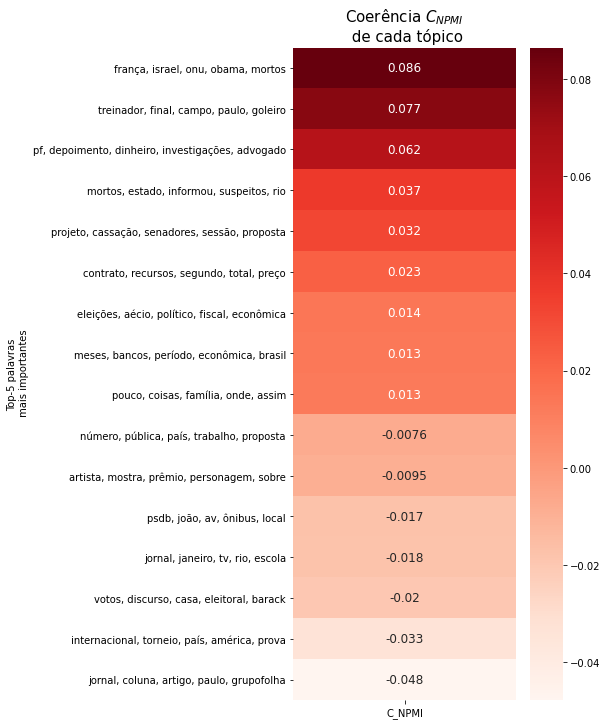

In [ ]:
fig, ax = plt.subplots( figsize=(5, 12) )
sns.heatmap(data=data_nmf, 
            ax=ax, cmap='Reds', 
            annot=True, annot_kws={'fontsize':12} )

ax.set_title("Coerência $C_{NPMI}$\n de cada tópico", fontsize=15)
ax.set_ylabel( "Top-5 palavras\n mais importantes" )
fig.show()